# 1. Import Library

In [1]:
# Simple CNN model for the CIFAR-10 Dataset
import numpy
from keras.datasets import cifar10
import numpy as np
np.random.seed(10)

Using TensorFlow backend.


# 資料準備

In [2]:
(X_img_train, y_label_train), (X_img_test, y_label_test) = cifar10.load_data()

In [3]:
print("train data:",'images:',X_img_train.shape," labels:",y_label_train.shape) 
print("test  data:",'images:',X_img_test.shape ," labels:",y_label_test.shape) 

train data: images: (50000, 32, 32, 3)  labels: (50000, 1)
test  data: images: (10000, 32, 32, 3)  labels: (10000, 1)


In [4]:
X_img_train_normalize = X_img_train.astype('float32') / 255.0
X_img_test_normalize = X_img_test.astype('float32') / 255.0

In [5]:
from keras.utils import np_utils
y_label_train_OneHot = np_utils.to_categorical(y_label_train)
y_label_test_OneHot = np_utils.to_categorical(y_label_test)

In [6]:
y_label_test_OneHot.shape

(10000, 10)

# 建立模型

In [7]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
import numpy as np

In [8]:
#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False, classes=10)
model_vgg16_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [9]:
#Create your own input format (here 32x32x3)
input = Input(shape=(32,32,3),name = 'image_input')

In [10]:
#Use the generated model 
output_vgg16_conv = model_vgg16_conv(input)

In [11]:
#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(512, activation='relu', name='fc1')(x)
#x = Dropout(0.4)(x)
x = Dense(128, activation='relu', name='fc2')(x)
#x = Dropout(0.4)(x)
#x = Dense(2048, activation='relu', name='fc3')(x)
#x = Dropout(0.4)(x)
#x = Dense(256, activation='relu', name='fc4')(x)
x = Dense(10, activation='softmax', name='predictions')(x)

In [12]:
#Create your own model 
my_model = Model(input=input, output=x)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  


In [13]:
#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 32, 32, 3)         0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               262656    
_________________________________________________________________
fc2 (Dense)                  (None, 128)               65664     
_________________________________________________________________
predictions (Dense)          (None, 10)                1290      
Total params: 15,044,298
Trainable params: 15,044,298
Non-trainable params: 0
________________________________________________________________

In [14]:
#If you want to change only the last layer :

# Generate a model with all layers (with top)
#vgg16 = VGG16(weights=None, include_top=True)

#Add a layer where input is the output of the  second last layer 
#x = Dense(8, activation='softmax', name='predictions')(vgg16.layers[-2].output)

#Then create the corresponding model 
#my_model = Model(input=vgg16.input, output=x)
#my_model.summary()

# 訓練模型

In [15]:
from keras.models import optimizers

#, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0
opt_adam = optimizers.Adam( lr=0.0001, beta_1=0.9, beta_2=0.99999, decay=0.00001 )

In [16]:
my_model.compile(loss='categorical_crossentropy', optimizer= opt_adam, metrics=['accuracy'])

In [17]:
from keras.preprocessing.image import ImageDataGenerator

print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

Using real-time data augmentation.


In [18]:
# Fit the model on the batches generated by datagen.flow().
train_history = my_model.fit_generator(
                    datagen.flow(X_img_train_normalize, y_label_train_OneHot, batch_size=2000),
                    epochs=200,
                    validation_data=(X_img_test_normalize, y_label_test_OneHot)
                    )

Epoch 1/200
25/25 [==============================] - 17s 684ms/step - loss: 1.7418 - acc: 0.3828 - val_loss: 1.1963 - val_acc: 0.5724
Epoch 2/200
25/25 [==============================] - 17s 678ms/step - loss: 1.0995 - acc: 0.6071 - val_loss: 0.8572 - val_acc: 0.6942
Epoch 3/200
25/25 [==============================] - 17s 687ms/step - loss: 0.9007 - acc: 0.6823 - val_loss: 0.7532 - val_acc: 0.7362
Epoch 4/200
25/25 [==============================] - 17s 694ms/step - loss: 0.7986 - acc: 0.7153 - val_loss: 0.6709 - val_acc: 0.7613
Epoch 5/200
25/25 [==============================] - 17s 685ms/step - loss: 0.7380 - acc: 0.7391 - val_loss: 0.6879 - val_acc: 0.7641
Epoch 6/200
25/25 [==============================] - 16s 657ms/step - loss: 0.6968 - acc: 0.7555 - val_loss: 0.5992 - val_acc: 0.7857
Epoch 7/200
25/25 [==============================] - 17s 691ms/step - loss: 0.6470 - acc: 0.7710 - val_loss: 0.5775 - val_acc: 0.7921
Epoch 8/200
25/25 [==============================] - 18s 723ms

In [19]:
import matplotlib.pyplot as plt
def show_train_history(train_token,test_token):
    plt.plot(train_history.history[train_token])
    plt.plot(train_history.history[test_token])
    plt.title('Train History')
    #plt.ylabel('Accuracy')
    plt.ylabel(train_token)
    plt.xlabel('Epoch')
    plt.legend([train_token, test_token], loc='upper left')
    plt.show()

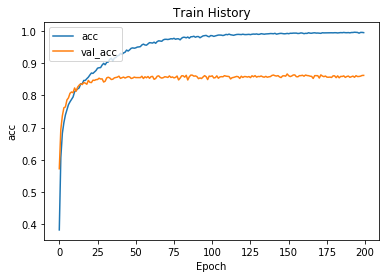

In [20]:
show_train_history('acc','val_acc')

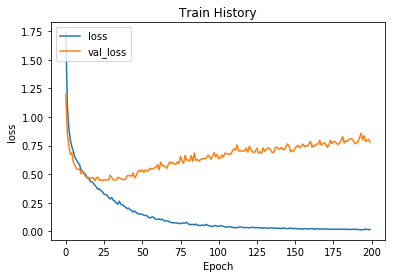

In [21]:
show_train_history('loss','val_loss')

# 評估模型準確率

In [22]:
scores = my_model.evaluate(X_img_test_normalize, 
                        y_label_test_OneHot,verbose=0)
scores[1]

0.86180000000000001

# 進行預測

In [23]:
pred=my_model.predict(X_img_test_normalize)

In [24]:
pred[0]

array([  4.52048787e-10,   4.28563164e-13,   2.29989270e-12,
         1.00000000e+00,   9.35075462e-10,   7.12098647e-09,
         9.74722256e-13,   9.29064395e-11,   5.51286122e-13,
         4.60296471e-12], dtype=float32)

In [25]:
prediction = numpy.empty(10000)
for i in range(pred.shape[0]):
    prediction[i] = np.argmax(pred[i])

In [26]:
prediction[0]

3.0

In [27]:
label_dict={0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",
            5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

In [28]:
import matplotlib.pyplot as plt

def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: num=25 
    for i in range(idx, idx+num):
        ax=plt.subplot(5,5, 1+(i-idx))
        ax.imshow(images[i],cmap='binary')
                
        title=str(i)+','+label_dict[labels[i][0]]
        if len(prediction)>0:
            title+='=>'+label_dict[prediction[i]]
            
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);ax.set_yticks([])        
        #idx+=1 
    plt.show()

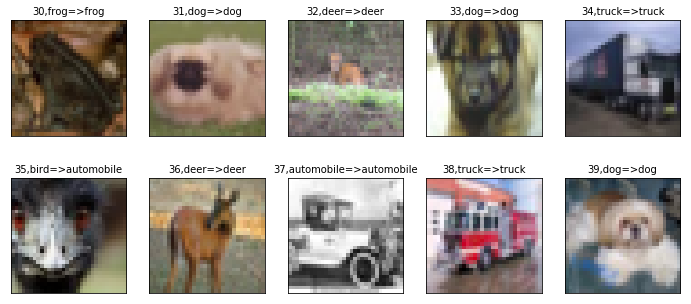

In [29]:
plot_images_labels_prediction(X_img_test_normalize,y_label_test,
                              prediction,30,10)

# 查看預測機率

In [30]:
Predicted_Probability=my_model.predict(X_img_test_normalize)

In [31]:
def show_Predicted_Probability(X_img,Predicted_Probability,i):
    plt.figure(figsize=(2,2))
    plt.imshow(np.reshape(X_img_test[i],(32,32,3)))
    plt.show()
    for j in range(10):
        print(label_dict[j]+' Probability:%1.9f'%(Predicted_Probability[i][j]))

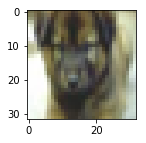

airplane Probability:0.000001648
automobile Probability:0.000180719
bird Probability:0.002724006
cat Probability:0.002099292
deer Probability:0.002982419
dog Probability:0.990509748
frog Probability:0.000049068
horse Probability:0.001305174
ship Probability:0.000041312
truck Probability:0.000106616


In [32]:
show_Predicted_Probability(X_img_test,Predicted_Probability,33)

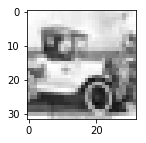

airplane Probability:0.000000013
automobile Probability:0.671713948
bird Probability:0.000000003
cat Probability:0.000000012
deer Probability:0.000000000
dog Probability:0.000000000
frog Probability:0.000000000
horse Probability:0.000000003
ship Probability:0.000000003
truck Probability:0.328286082


In [33]:
show_Predicted_Probability(X_img_test,Predicted_Probability,37)

# confusion matrix

In [34]:
import pandas as pd
print(label_dict)
pd.crosstab(y_label_test.reshape(-1),prediction,
            rownames=['label'],colnames=['predict'])

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


predict,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
label,,,,,,,,,,
0,886,7,15,7,7,0,4,8,45,21
1,5,935,0,2,0,2,1,1,9,45
2,27,3,846,20,39,24,24,9,5,3
3,13,3,39,717,18,126,44,22,10,8
4,7,2,51,29,799,22,38,37,7,8
5,3,3,24,109,15,793,11,31,7,4
6,5,5,24,32,14,15,899,1,4,1
7,9,1,10,16,16,28,2,907,3,8
8,24,9,7,3,3,0,2,1,936,15


# Save model to JSON

In [34]:
model_json = my_model.to_json()
with open("SaveModel/cifarVGG16Model.json", "w") as json_file:
    json_file.write(model_json)

# Save Model to YAML

In [35]:
model_yaml = my_model.to_yaml()
with open("SaveModel/cifarVGG16Model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)


# Save Weight to h5 

In [36]:
my_model.save_weights("SaveModel/cifarVGG16Model.h5")
print("Saved model to disk")

Saved model to disk
